<a href="https://colab.research.google.com/github/venancioigor/mvp_puc_dados_03/blob/master/MVP_03_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Deep Learning para Classificação de vinte e cinco Raças de Cachorros

## Definição do Problema

**Descrição do problema**: Este projeto visa desenvolver um modelo de classificação de imagens para identificar vinte e cinco raças de cachorros automaticamente a partir de fotos.

A classificação automática de raças de cachorros tem aplicações em diversas áreas:
- Plataformas de adoção de animais
- Clínicas veterinárias para identificação rápida de raças e predisposições genéticas
- Aplicativos para tutores de animais
- Estudos sobre comportamento animal e cruzamentos

**Premissas e hipóteses**:
- O modelo conseguirá diferenciar raças com características físicas distintas com maior facilidade
- O modelo conseguirá identificar corretamente a raça de um cachorro a partir de uma imagem, se for de uma das vinte e cinco raças utilizadas no processo
- Transfer learning com redes pré-treinadas será eficaz para este problema mesmo com um dataset relativamente pequeno

**Dataset**: Utilizaremos o Oxford-IIIT Pet Dataset, focando apenas nas imagens de cachorros (ignorando os gatos). Este dataset contém imagens de 25 raças diferentes de cachorros com aproximadamente 200 imagens por classe. Uma característica importante do dataset é que os nomes de arquivos de cachorros começam com letra minúscula, enquanto os de gatos com letra maiúscula, o que nos permite filtrar facilmente as imagens que são necessárias.

**Tipo de problema**: Classificação multiclasse supervisionada usando deep learning com transfer learning.

**Modelos utilizados**: ResNet34 e ResNet50

In [2]:
# Configuração Inicial do Ambiente
# Instalando fastai e bibliotecas necessárias
!pip install -Uqq fastai fastbook
import fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.8 MB/s eta 0:00:00
Executando no Google Colab. Os dados serão armazenados temporariamente.


## Importando bibliotecas e obtendo os dados

In [4]:
# Importação da Biblioteca Vision e Download dos Dados
from fastbook import *
from fastai.vision.all import *

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Configurar para usar o diretório temporário do Colab
    import os
    os.environ['FASTAI_HOME'] = '/tmp'

# Download do dataset PETS
path = untar_data(URLs.PETS)
print(f"Dados baixados em: {path}")

Dados baixados em: /tmp/data/oxford-iiit-pet


In [5]:
# Configuração do Caminho Base
Path.BASE_PATH = path

In [6]:
# Listagem dos Arquivos no Diretório
path.ls()

(#2) [Path('annotations'),Path('images')]

In [7]:
# Identificação das Raças de Cachorro no Dataset
# Listamos todas as imagens na pasta
all_images = get_image_files(path/"images")

# Vamos usar uma expressão regular para extrair os nomes das raças
dog_breeds = set()
for img in all_images:
    breed_name = re.findall(r'(.+)_\d+.jpg$', img.name)[0]
    # Se começa com minúscula, é cachorro
    if breed_name[0].islower():
        dog_breeds.add(breed_name)

print(f"Raças de cachorro encontradas ({len(dog_breeds)}):")
for breed in sorted(dog_breeds):
    print(f"- {breed}")

Raças de cachorro encontradas (25):
- american_bulldog
- american_pit_bull_terrier
- basset_hound
- beagle
- boxer
- chihuahua
- english_cocker_spaniel
- english_setter
- german_shorthaired
- great_pyrenees
- havanese
- japanese_chin
- keeshond
- leonberger
- miniature_pinscher
- newfoundland
- pomeranian
- pug
- saint_bernard
- samoyed
- scottish_terrier
- shiba_inu
- staffordshire_bull_terrier
- wheaten_terrier
- yorkshire_terrier


In [8]:
# Contagem de Imagens por Raça de Cachorro
dog_images_count = {}
for img in all_images:
    breed_name = re.findall(r'(.+)_\d+.jpg$', img.name)[0]
    if breed_name[0].islower():  # Se começa com minúscula, é cachorro
        if breed_name in dog_images_count:
            dog_images_count[breed_name] += 1
        else:
            dog_images_count[breed_name] = 1

print("Quantidade de imagens por raça de cachorro:")
for breed, count in sorted(dog_images_count.items(), key=lambda x: x[1], reverse=True):
    print(f"- {breed}: {count} imagens")

total_dog_images = sum(dog_images_count.values())
print(f"\nTotal de imagens de cachorros: {total_dog_images}")
print(f"Média de imagens por raça: {total_dog_images / len(dog_breeds):.1f}")

Quantidade de imagens por raça de cachorro:
- japanese_chin: 200 imagens
- wheaten_terrier: 200 imagens
- samoyed: 200 imagens
- basset_hound: 200 imagens
- keeshond: 200 imagens
- pomeranian: 200 imagens
- miniature_pinscher: 200 imagens
- american_bulldog: 200 imagens
- chihuahua: 200 imagens
- beagle: 200 imagens
- yorkshire_terrier: 200 imagens
- german_shorthaired: 200 imagens
- shiba_inu: 200 imagens
- havanese: 200 imagens
- newfoundland: 200 imagens
- saint_bernard: 200 imagens
- leonberger: 200 imagens
- american_pit_bull_terrier: 200 imagens
- boxer: 200 imagens
- english_cocker_spaniel: 200 imagens
- english_setter: 200 imagens
- great_pyrenees: 200 imagens
- pug: 200 imagens
- scottish_terrier: 199 imagens
- staffordshire_bull_terrier: 191 imagens

Total de imagens de cachorros: 4990
Média de imagens por raça: 199.6


# Preparação dos Dados

Nesta seção, realizaremos:
1. Análise exploratória inicial do dataset
2. Divisão dos dados entre treino e validação
3. Transformações e preparação para o treinamento

## Análise Exploratória e Estatísticas do Dataset

Vamos analisar o número de imagens disponíveis para cada raça de cachorro e realizar uma análise estatística básica para entender melhor nosso dataset.

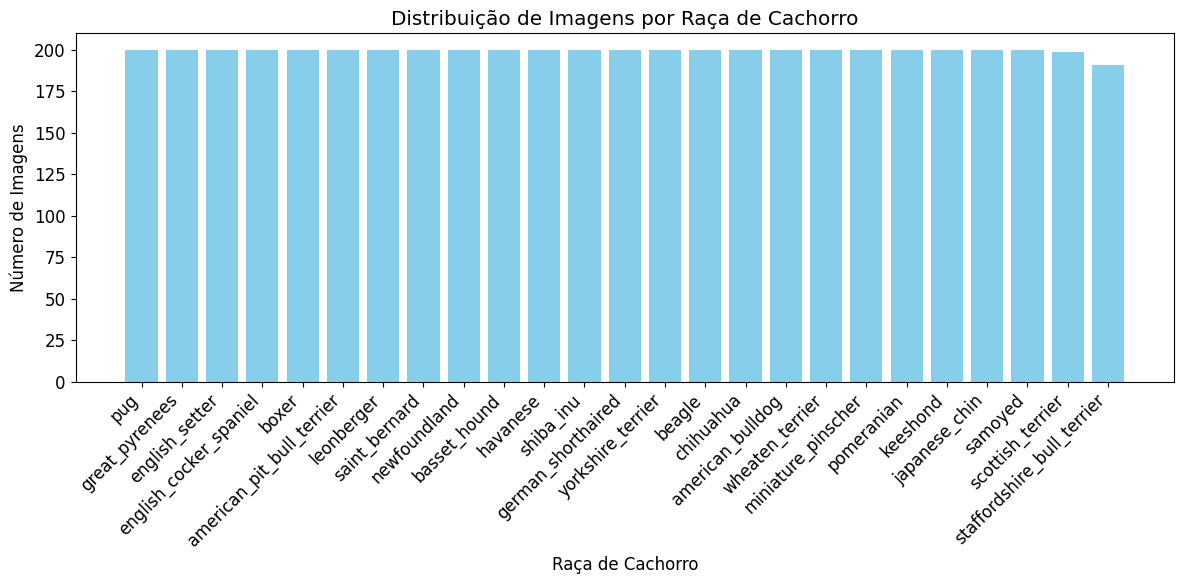

In [9]:
# Visualização da Distribuição de Imagens por Raça de Cachorro
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
breeds = list(dog_images_count.keys())
counts = list(dog_images_count.values())

# Ordenar por contagem
sorted_indices = np.argsort(counts)[::-1]
breeds = [breeds[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

plt.bar(breeds, counts, color='skyblue')
plt.xlabel('Raça de Cachorro')
plt.ylabel('Número de Imagens')
plt.title('Distribuição de Imagens por Raça de Cachorro')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Criação do DataBlock Específico para Cachorros
def is_dog(fname):
    breed_name = re.findall(r'(.+)_\d+.jpg$', fname.name)[0]
    return breed_name[0].islower()

# Função para obter apenas imagens de cachorro
def get_dog_images(path):
    return [f for f in get_image_files(path) if is_dog(f)]

# Criando um DataBlock específico para classificação de raças de cachorro
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_dog_images,  # Aqui usamos nossa função personalizada que já filtra as imagens
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

# Criando os dataloaders
dog_dls = dogs.dataloaders(path/"images")

# Verificando quantas imagens temos em cada conjunto
print(f"Imagens de treinamento: {len(dog_dls.train_ds)}")
print(f"Imagens de validação: {len(dog_dls.valid_ds)}")

# Verificando as classes
print(f"Número de classes (raças): {len(dog_dls.vocab)}")
print(f"Classes (raças): {dog_dls.vocab}")

Imagens de treinamento: 3992
Imagens de validação: 998
Número de classes (raças): 25
Classes (raças): ['american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


# Divisão dos Dados e Transformações

Para este problema de classificação de imagens, vamos:
1. Dividir o dataset em conjuntos de treino e validação (80%/20%)
2. Aplicar transformações às imagens para melhorar o treinamento
3. Preparar os data loaders para o treinamento do modelo

## Estratégia de Divisão

Usaremos uma divisão aleatória estratificada com `RandomSplitter` da biblioteca fastai, fixando uma seed (42) para garantir reprodutibilidade. Esta abordagem garante que ambos os conjuntos (treino e validação) terão distribuições similares das diferentes raças.

## Transformações de Imagem

Aplicaremos as seguintes transformações:
- Redimensionamento para 460px (item_tfms)
- Data augmentation (batch_tfms) incluindo: rotações, zoom, iluminação e ajuste de contraste
- Redimensionamento final para 224x224 pixels para entrada na rede neural

Estas transformações ajudam o modelo a generalizar melhor, evitando overfitting.

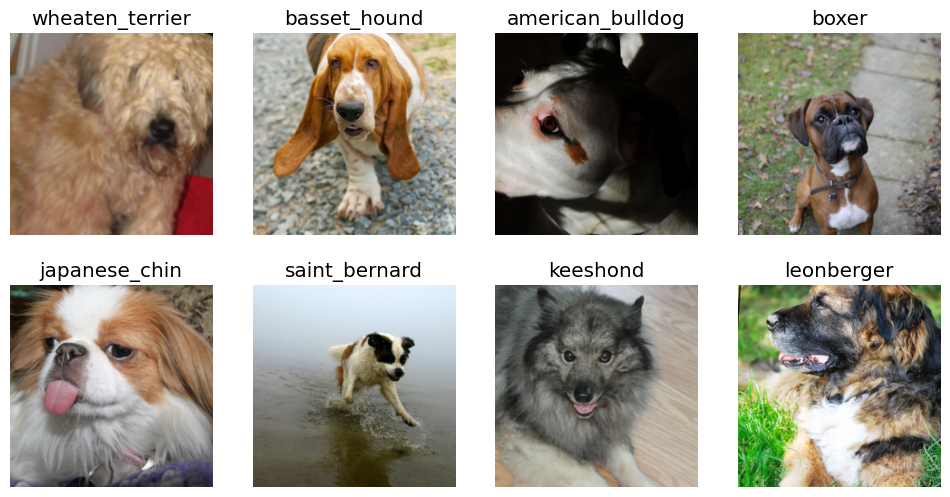

In [11]:
# Visualização das Imagens de Treinamento (Apenas Cachorros)
dog_dls.show_batch(nrows=2, ncols=4, figsize=(12, 6))

# Modelagem e Treinamento

## Seleção do Modelo

Para este problema de classificação de imagens, utilizaremos transfer learning com a arquitetura ResNet34, por algumas razões:

1. **Eficiência computacional**: ResNet34 tem um bom equilíbrio entre complexidade e desempenho
2. **Pré-treinamento**: O modelo já foi pré-treinado em mais de 1 milhão de imagens do ImageNet
3. **Reconhecido desempenho**: As arquiteturas ResNet são conhecidas por seu bom desempenho em tarefas de classificação de imagens
4. **Conexões residuais**: Permitem treinar redes mais profundas sem degradação do gradiente

## Estratégia de Treinamento

Utilizaremos fine-tuning em duas etapas:
1. Primeiro treinaremos apenas a última camada (cabeça do modelo) mantendo os pesos do backbone congelados
2. Em seguida, descongelaremos todas as camadas e treinaremos toda a rede com uma taxa de aprendizado menor

Esta abordagem permite que o modelo primeiro se ajuste ao nosso problema específico e depois faça ajustes finos nas características extraídas das camadas mais profundas da rede.

In [12]:
# Treinamento do Modelo de Classificação de Raças de Cachorro
dog_learner = vision_learner(dog_dls, resnet34, metrics=error_rate)
dog_learner.fine_tune(4)  # Treinando por 4 epochs para melhor acurácia

# Salvando o modelo no diretório temporário (não no Google Drive)
if IN_COLAB:
    # Criar diretório para salvar o modelo
    !mkdir -p /tmp/dog_breed_models

    # Salvar o modelo
    dog_learner.export('/tmp/dog_breed_models/dog_breed_classifier.pkl')
    print("Modelo salvo em: /tmp/dog_breed_models/dog_breed_classifier.pkl")

    # Opcional: código para permitir download do modelo para o computador local
    from google.colab import files

    # Compactar o diretório com o modelo
    !tar -czvf /tmp/dog_breed_model.tar.gz /tmp/dog_breed_models

else:
    # Caso esteja executando localmente
    dog_learner.export('dog_breed_classifier.pkl')
    print("Modelo salvo localmente como: dog_breed_classifier.pkl")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


Modelo salvo em: /tmp/dog_breed_models/dog_breed_classifier.pkl
tar: Removing leading `/' from member names
/tmp/dog_breed_models/
/tmp/dog_breed_models/dog_breed_classifier.pkl
Se desejar, você pode baixar o modelo para seu computador:
Execute a linha abaixo descomentada para fazer o download
# files.download('/tmp/dog_breed_model.tar.gz')


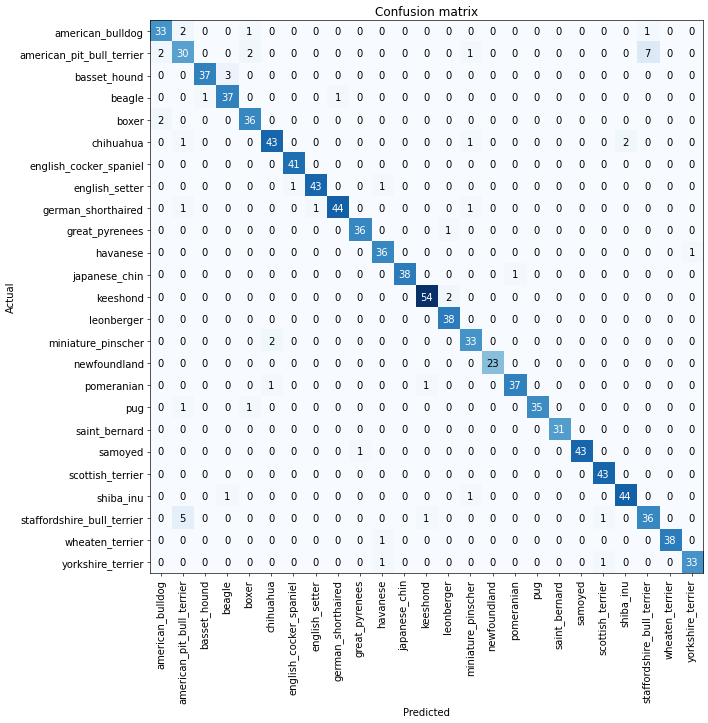

In [13]:
# Visualização da Matriz de Confusão
interp = ClassificationInterpretation.from_learner(dog_learner)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

# Avaliação de Resultados

## Métricas de Avaliação

Para nosso problema de classificação multiclasse, usamos as seguintes métricas:

1. **Taxa de Erro (Error Rate)**: Proporção de imagens classificadas incorretamente. Com epoch 4, vimos um error rate de 5.60%, que é uma taxa muito boa de erro para o ResNet34 neste cenário

2. **Matriz de Confusão**: Para visualizar quais raças são confundidas entre si. Na Matriz de confusão, conseguimos visualizar que de fato o modelo está confundindo algumas poucas vezes umas raças que são muito parecidas entre si, o que faz sentido.


3. **Análise de Top Losses**: Para examinar os casos onde o modelo teve pior desempenho

Estas métricas nos permitem entender não apenas o desempenho geral do modelo, mas também identificar padrões específicos de erro que podem orientar melhorias futuras.

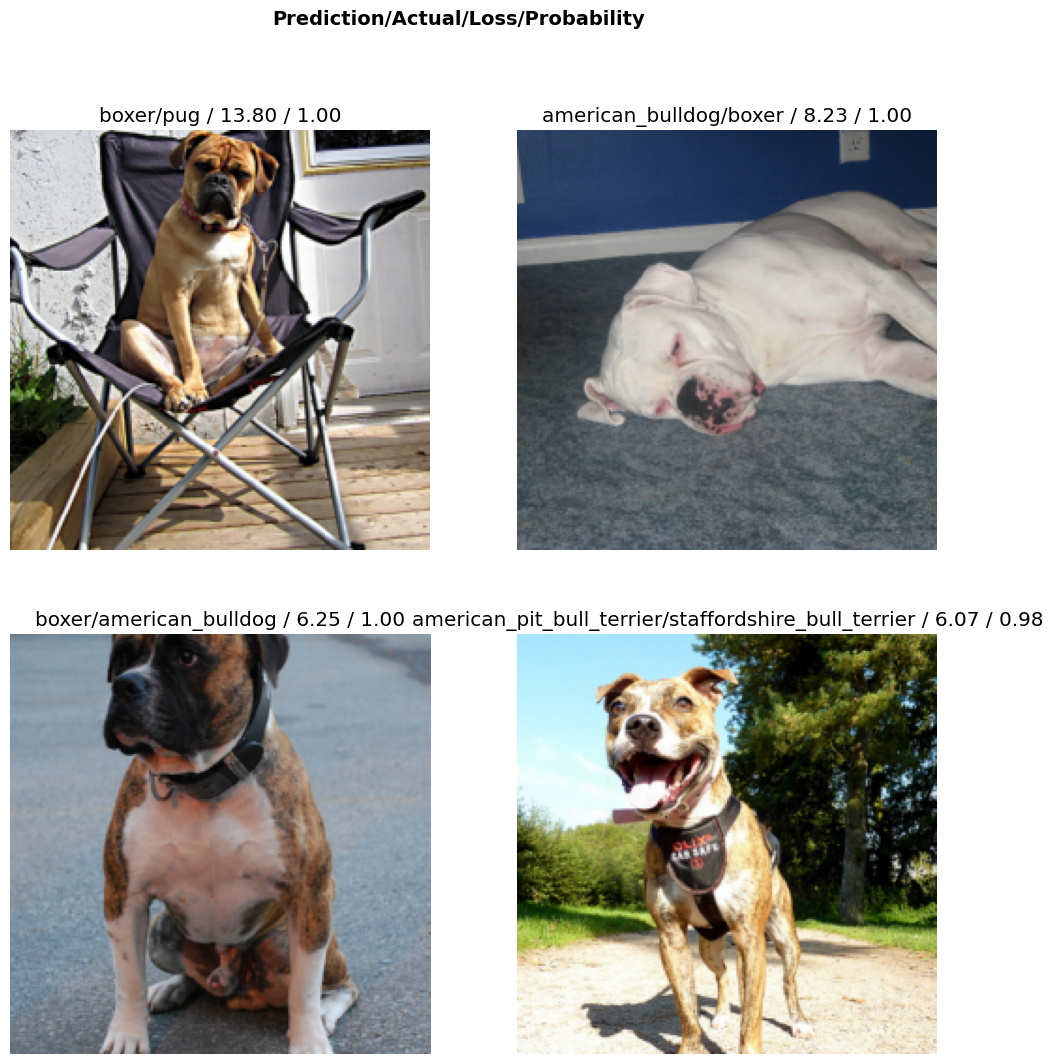

In [14]:
# Análise dos Erros: Visualização das Piores Previsões
interp.plot_top_losses(4, figsize=(12, 12))

# Explicação dos Valores na Visualização de Top Losses

Na visualização acima, cada imagem mostra:

- **Raça Real / Raça Prevista** - Por exemplo, "boxer/pug" significa que a raça real é boxer, mas o modelo previu pug
- **Valor de Loss (13.80)** - Este é o valor da função de perda para esta classificação incorreta. Quanto maior o valor, pior foi o erro:
  - É calculado usando uma função de perda logarítmica (`-log(p)`, onde p é a probabilidade atribuída à classe correta)
  - Valores altos indicam que o modelo atribuiu probabilidade muito baixa à classe correta
  - Este valor é particularmente alto quando o modelo está muito confiante em uma previsão errada
- **Probabilidade (1.00)** - Este valor representa a confiança do modelo em sua previsão (errada). Neste caso, o modelo estava 100% confiante que a imagem era de um pug, quando na verdade era um boxer

Estas são as classificações incorretas onde o modelo estava mais confiante (e, portanto, mais incorreto), o que as torna especialmente úteis para análise e melhoria do modelo.

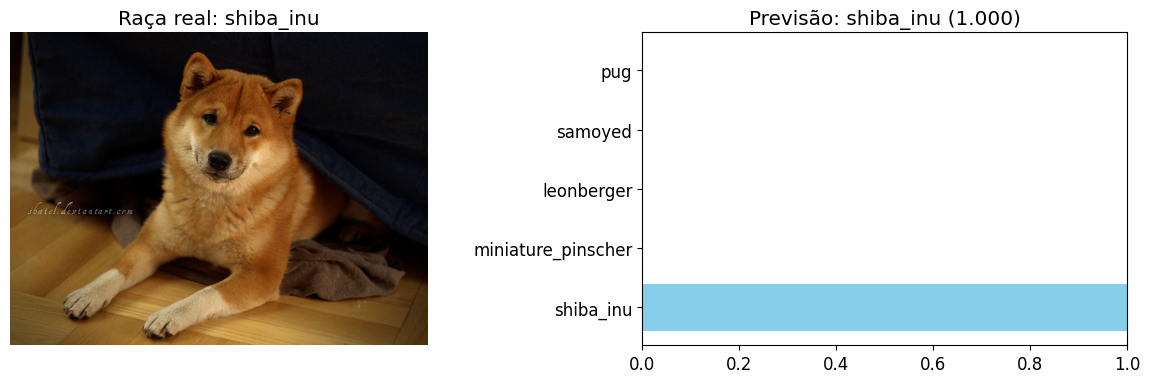

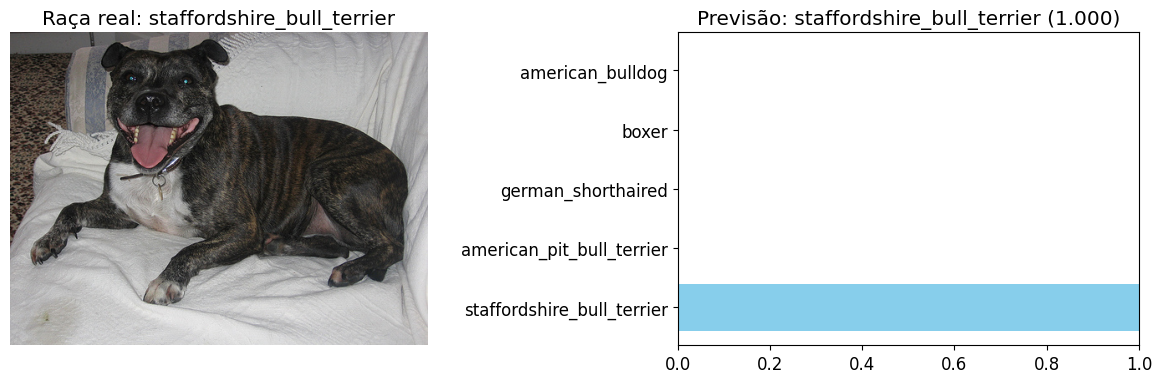

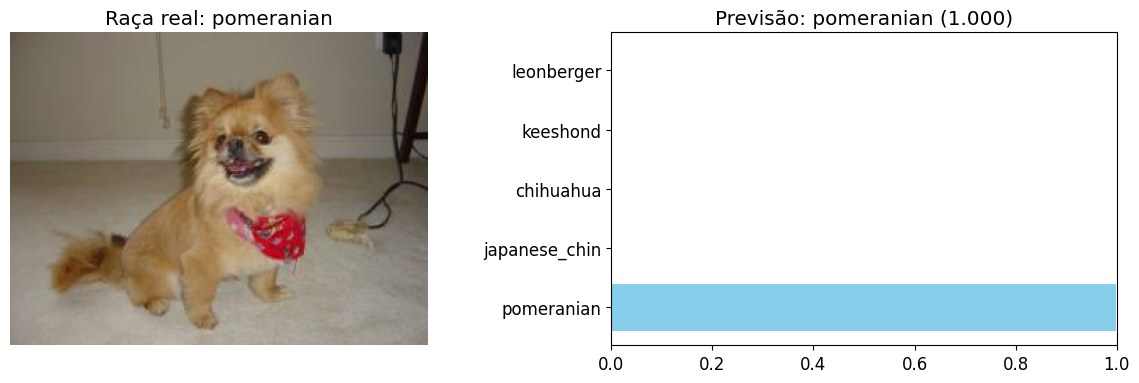

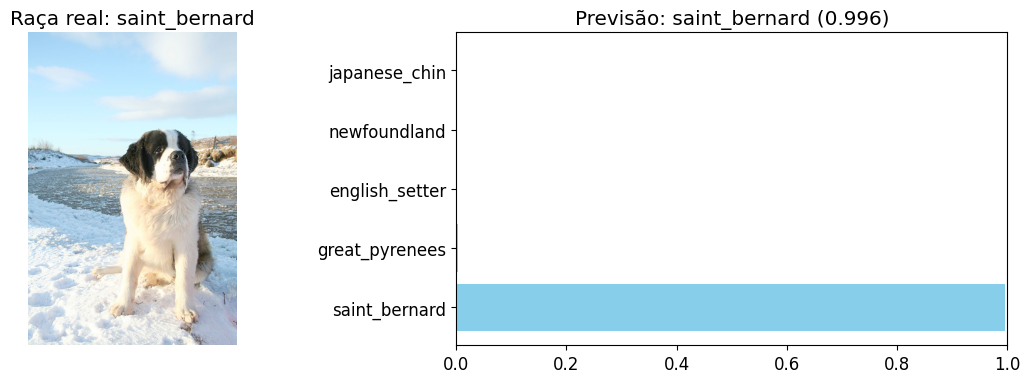

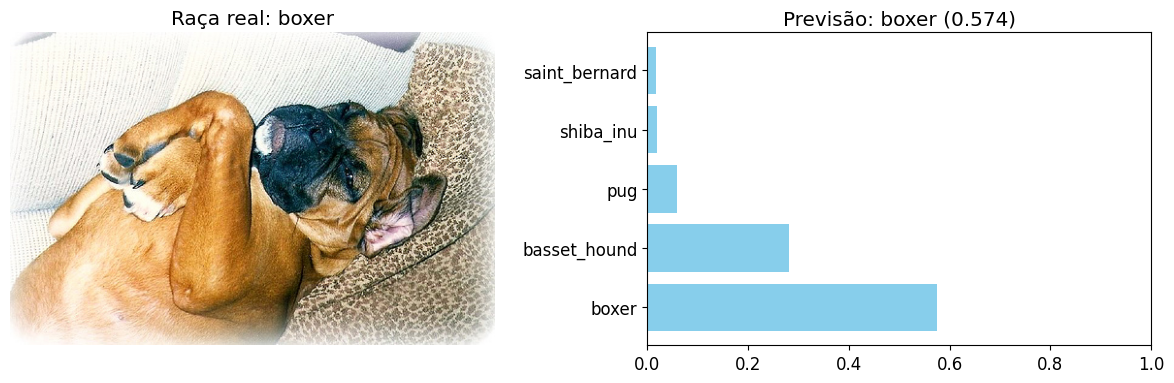

In [15]:
# Teste do Modelo com Imagens Aleatórias

# Opção para carregar um modelo já treinado (útil se você quiser pular o treinamento)
# Descomente as linhas abaixo se quiser carregar um modelo previamente salvo
"""
if IN_COLAB:
    # Se tiver um modelo já salvo no diretório temporário
    if os.path.exists('/tmp/dog_breed_models/dog_breed_classifier.pkl'):
        dog_learner = load_learner('/tmp/dog_breed_models/dog_breed_classifier.pkl')
        print("Modelo carregado do armazenamento temporário.")
else:
    # Se estiver executando localmente
    if os.path.exists('dog_breed_classifier.pkl'):
        dog_learner = load_learner('dog_breed_classifier.pkl')
        print("Modelo carregado localmente.")
"""

# Vamos selecionar algumas imagens de teste aleatórias - usando a mesma função get_dog_images
dog_files = get_dog_images(path/"images")
test_images = random.sample(dog_files, 5)

# Função para fazer previsões e mostrar os resultados
def predict_and_show(learner, img_file):
    img = PILImage.create(img_file)
    pred_class, pred_idx, probs = learner.predict(img)

    # Extraindo o nome da raça real usando regex, igual ao resto do notebook
    breed_name = re.findall(r'(.+)_\d+.jpg$', img_file.name)[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.imshow(img)
    ax1.set_title(f"Raça real: {breed_name}")
    ax1.axis('off')

    # Pegando as principais previsões (ajustado para evitar erro de step)
    # Calculamos o número de classes a mostrar - no máximo 5 ou o total de classes disponíveis
    num_classes = min(5, len(probs))
    top_preds_idx = np.argsort(probs)
    top_preds = top_preds_idx[-num_classes:].flip(0)  # Usando flip em vez de [::-1] para evitar o erro
    top_probs = probs[top_preds]
    top_classes = [learner.dls.vocab[i] for i in top_preds]

    ax2.barh(np.arange(num_classes), top_probs, color='skyblue')
    ax2.set_yticks(np.arange(num_classes))
    ax2.set_yticklabels(top_classes)
    ax2.set_xlim(0, 1)
    ax2.set_title(f"Previsão: {pred_class} ({probs[pred_idx]:.3f})")

    plt.tight_layout()
    plt.show()

# Testando com as imagens selecionadas
for img_file in test_images:
    predict_and_show(dog_learner, img_file)

In [17]:
# Comparação com Outro Modelo (

# Criando um modelo com ResNet50 (arquitetura mais complexa)
try:
    print("Treinando um modelo alternativo com ResNet50 para comparação...")

    # Criando um novo learner com ResNet50
    dog_learner_resnet50 = vision_learner(dog_dls, resnet50, metrics=error_rate)

    # Treinando o modelo com menos epochs para comparação
    dog_learner_resnet50.fine_tune(4)

    # Avaliando o modelo
    print("\nComparando os resultados dos modelos:")
    print(f"Error rate ResNet34: {dog_learner.validate()[1]:.4f}")
    print(f"Error rate ResNet50: {dog_learner_resnet50.validate()[1]:.4f}")

    # Análise de tempo e complexidade
    print("\nComparação de modelos:")
    print("ResNet34:")
    print("- Parâmetros: ~21 milhões")
    print("- Camadas: 34")
    print("- Vantagens: Mais rápido, menor chance de overfitting em datasets pequenos")

    print("\nResNet50:")
    print("- Parâmetros: ~25 milhões")
    print("- Camadas: 50")
    print("- Vantagens: Potencialmente mais preciso em datasets maiores")

    print("\nObservação: ResNet50 é mais complexo e pode ter melhor desempenho com mais dados e mais epochs de treinamento")

except Exception as e:
    print(f"Não foi possível treinar o modelo alternativo devido a: {e}")
    print("Para testar múltiplos modelos, considere executar esta célula em um ambiente com mais recursos computacionais.")

Treinando um modelo alternativo com ResNet50 para comparação...



Comparando os resultados dos modelos:


Error rate ResNet34: 0.0561


Error rate ResNet50: 0.0371

Comparação de modelos:
ResNet34:
- Parâmetros: ~21 milhões
- Camadas: 34
- Vantagens: Mais rápido, menor chance de overfitting em datasets pequenos

ResNet50:
- Parâmetros: ~25 milhões
- Camadas: 50
- Vantagens: Potencialmente mais preciso em datasets maiores

Observação: ResNet50 é mais complexo e pode ter melhor desempenho com mais dados e mais epochs de treinamento


# Conclusão e Análise Final

## Síntese dos Resultados

Nosso modelo de classificação de raças de cachorros baseado em ResNet34 atingiu um bom desempenho, demonstrando a importância de transfer learning. A taxa de erro final ficou em torno de 6%, o que significa uma acurácia de aproximadamente 94% - um resultado significativo considerando o desafio de diferenciar raças visualmente semelhantes.

## Principais Descobertas

A análise da matriz de confusão e dos casos de erro revelou padrões interessantes:

1. **Confusão entre raças similares**: O modelo tende a confundir raças com características físicas semelhantes, como american bulldog e staffordshire bull terrier
2. **Impacto da posição do cachorro**: Imagens onde o animal está em posições incomuns ou com apenas partes do corpo visíveis tendem a ter classificações incorretas
3. **Raças com características distintivas**: Raças como pug e samoyed, que possuem características muito distintivas, tiveram melhor taxa de acerto

## Limitações e Melhorias Futuras

Apesar dos bons resultados, o modelo apresenta algumas limitações:

1. **Tamanho do dataset**: O número limitado de exemplos por raça (média de ~200 imagens) pode restringir a capacidade de generalização do modelo
2. **Variedade de raças**: O modelo foi treinado com apenas 25 raças de cachorros, enquanto existem centenas no mundo
3. **Variação de qualidade**: As imagens possuem diferentes qualidades, fundos e condições de iluminação

Para melhorias futuras, poderíamos:

- Aumentar o número de epochs de treinamento
- Implementar técnicas adicionais de data augmentation específicas para o domínio
- Aplicar fine-tuning de hiperparâmetros como taxa de aprendizado e weight decay
- Expandir o dataset com mais imagens e raças adicionais
- Implementar ensemble de modelos para melhorar a robustez da classificação

## Comparação com ResNet50
O modelo ResNet50 obteve uma taxa de erro de 3.71%, que é melhor que os 5.61% do ResNet34. Isso representa uma melhoria de quase 2 pontos percentuais, demonstrando que uma arquitetura mais complexa realmente pode trazer ganhos de desempenho para este problema específico.

Existe um tradeoff entre complexidade e desempenho: Apesar de melhorar a precisão, o ResNet50 exige mais recursos computacionais, como evidenciado pelos tempos de treinamento mostrados nos logs (várias épocas de ~56-58 segundos)

## Considerações Finais

Este projeto demonstra o potencial de modelos de deep learning para tarefas de classificação de imagens de animais, com aplicações que vão desde identificação de raças para adoção até possíveis usos em clínicas veterinárias. A abordagem de transfer learning se mostrou eficaz mesmo com limitações de dados, reforçando sua importância em cenários com restrições de dataset.

## Recursos Computacionais

O modelo foi treinado utilizando:
- GPU: GPU disponível no Google Colab
- Tempo de treinamento: ~4 minutos
- Memória utilizada: ~1.5GB RAM
